<a href="https://colab.research.google.com/github/vamshichallabb/532Stories/blob/main/Vamshi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A Hybrid Variational Autoencoder with LSTM Encoder and SSA Decoder for Energy Prediction and Pattern Recognition in Bidirectional Space**

## _Short Summary:_

> This research proposes a novel Variational Autoencoder (VAE) architecture for energy prediction and pattern recognition in industrial datasets.

> The encoder employs a Long Short-Term Memory (LSTM) neural network to capture sequential dependencies and generate latent patterns from noisy, time-series data. The decoder applies Singular Spectrum Analysis (SSA) to generate reconstructed patterns.

> Both generated patterns are compared in a bidirectional latent space to observe and analyze energy dynamics and recognize recurring patterns efficiently.

> The proposed approach leverages the strengths of LSTM for temporal modeling and SSA for signal decomposition, offering improved accuracy and interpretability in energy prediction and pattern recognition tasks.



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import tensorflow as tf

## LSTM Encoder


In [ ]:
class LSTMEncoder(layers.Layer):
    def __init__(self, latent_dim, intermediate_dim):
        super(LSTMEncoder, self).__init__()
        self.lstm = layers.LSTM(intermediate_dim, return_sequences=False)
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)

    def call(self, inputs):
        x = self.lstm(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        return z_mean, z_log_var


NameError: name 'layers' is not defined

## SSA Decoder

In [ ]:
class SSADecoder(layers.Layer):
    def __init__(self, sequence_length, feature_dim, window_size):
        super(SSADecoder, self).__init__()
        self.sequence_length = sequence_length
        self.feature_dim = feature_dim
        self.window_size = window_size

        # Decoder network
        self.dense_layers = [
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(sequence_length * feature_dim)
        ]

    def apply_ssa(self, series):
        # Convert to matrix form
        L = self.window_size
        K = self.sequence_length - L + 1

        # Build trajectory matrix using slicing
        trajectory_matrix = tf.stack([series[i:i+L] for i in range(K)])

        # SVD
        s, u, v = tf.linalg.svd(trajectory_matrix)

        # Reconstruction using first component
        s1 = s[0]
        u1 = u[:, 0:1]
        v1 = v[0:1, :]

        reconstructed_matrix = s1 * tf.matmul(u1, v1)

        # Diagonal averaging
        series_len = self.sequence_length
        reconstructed = tf.zeros(series_len, dtype=tf.float32)
        counts = tf.zeros(series_len, dtype=tf.float32)

        # Using updates for diagonal averaging
        for i in range(L):
            for j in range(K):
                pos = i + j
                if pos < series_len:
                    reconstructed = reconstructed + tf.scatter_nd(
                        [[pos]], [reconstructed_matrix[j, i]], [series_len]
                    )
                    counts = counts + tf.scatter_nd(
                        [[pos]], [1.0], [series_len]
                    )

        # Final averaging
        reconstructed = reconstructed / (counts + 1e-10)
        return reconstructed

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        # Pass through dense layers
        x = inputs
        for layer in self.dense_layers:
            x = layer(x)

        # Reshape to sequence
        x = tf.reshape(x, [batch_size, self.sequence_length, self.feature_dim])

        # Apply SSA to each sequence in the batch
        def process_sequence(sequence):
            # Handle single feature dimension
            flat_seq = tf.reshape(sequence, [self.sequence_length])
            reconstructed = self.apply_ssa(flat_seq)
            return tf.reshape(reconstructed, [self.sequence_length, self.feature_dim])

        reconstructed = tf.map_fn(process_sequence, x)
        return reconstructed

NameError: name 'layers' is not defined

## VAE Model

In [ ]:
class VAE(models.Model):
    def __init__(self, latent_dim, intermediate_dim, sequence_length, feature_dim, window_size):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = LSTMEncoder(latent_dim, intermediate_dim)
        self.decoder = SSADecoder(sequence_length, feature_dim, window_size)

    def reparameterize(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        epsilon = tf.random.normal(shape=(batch_size, self.latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        return reconstructed, z_mean, z_log_var

    def train_step(self, data):
        with tf.GradientTape() as tape:
            reconstructed, z_mean, z_log_var = self(data)

            # Reconstruction loss (MSE)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(data - reconstructed), axis=[1, 2])
            )

            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )

            # Total loss with beta-VAE weighting
            beta = 0.1  # Adjust this to control KL term importance
            total_loss = reconstruction_loss + beta * kl_loss

        # Compute and apply gradients
        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss
        }

## *Loss Function*

In [ ]:
def vae_loss(original, reconstructed, z_mean, z_log_var):
    reconstruction_loss = tf.reduce_mean(tf.square(original - reconstructed))
    kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    return reconstruction_loss + kl_loss

In [ ]:
def create_vae_model(config):
    """Create and compile VAE model with given configuration."""
    model = VAE(
        latent_dim=config['latent_dim'],
        intermediate_dim=config['intermediate_dim'],
        sequence_length=config['sequence_length'],
        feature_dim=config['feature_dim'],
        window_size=config['window_size']
    )

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    return model

## Compile and Train the Model

In [ ]:
# Configuration
config = {
    'latent_dim': 32,
    'intermediate_dim': 64,
    'window_size': 10,
    'sequence_length': 50,
    'feature_dim': 1
}

# Create model
model = create_vae_model(config)

# Example training data
X_train = np.random.randn(100, 50, 1)  # 100 samples, 50 timesteps, 1 feature

# Train model
history = model.fit(X_train, epochs=10, batch_size=32)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 38s 130ms/step - kl_loss: 0.0171 - loss: 50.6068 - reconstruction_loss: 50.6050
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - kl_loss: 0.0306 - loss: 52.3287 - reconstruction_loss: 52.3256
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - kl_loss: 0.0230 - loss: 52.2034 - reconstruction_loss: 52.2011
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - kl_loss: 0.0363 - loss: 49.2444 - reconstruction_loss: 49.2407
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - kl_loss: 0.0334 - loss: 51.1142 - reconstruction_loss: 51.1109
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - kl_loss: 0.0304 - loss: 50.3117 - reconstruction_loss: 50.3086
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - kl_loss: 0.0301 - loss: 50.9806 - reconstruction_loss: 50.9776
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - kl_loss: 0.0326 - loss: 51.1460 - reconstruction_loss: 51.1428
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - kl_loss: 0.0447 - loss: 51.

# Report

In [ ]:
def plot_reconstructions(model, X_test, num_examples=5):
    """
    Plot original vs reconstructed sequences for multiple test examples
    """
    # Get reconstructions
    reconstructed, _, _ = model(X_test[:num_examples])
    reconstructed = reconstructed.numpy()

    # Create figure
    fig, axes = plt.subplots(num_examples, 1, figsize=(15, 3*num_examples))
    if num_examples == 1:
        axes = [axes]

    time_steps = np.arange(X_test.shape[1])

    for i in range(num_examples):
        # Plot original sequence
        axes[i].plot(time_steps, X_test[i, :, 0], 'b-', label='Original', alpha=0.7)
        # Plot reconstruction
        axes[i].plot(time_steps, reconstructed[i, :, 0], 'r--', label='Reconstructed', alpha=0.7)
        axes[i].set_title(f'Sample {i+1}')
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    return fig

def visualize_latent_space(model, X_test, num_samples=100):
    """
    Visualize the latent space using t-SNE
    """
    # Ensure we don't exceed the number of available samples
    num_samples = min(num_samples, len(X_test))

    # Get latent representations
    z_mean, _ = model.encoder(X_test[:num_samples])
    z_mean = z_mean.numpy()

    # Reduce dimensionality for visualization using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    z_2d = tsne.fit_transform(z_mean)

    # Create scatter plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create color map based on temporal position
    colors = np.linspace(0, 1, num_samples)

    scatter = ax.scatter(z_2d[:, 0], z_2d[:, 1],
                        c=colors,
                        cmap='viridis',
                        alpha=0.6)

    plt.colorbar(scatter, label='Temporal Position')
    ax.set_title('Latent Space Visualization (t-SNE)')
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.grid(True)

    return fig

def plot_loss_history(history):
    """
    Plot training history
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot total loss
    ax1.plot(history.history['loss'], 'b-')
    ax1.set_title('Total Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    # Plot component losses
    ax2.plot(history.history['reconstruction_loss'], 'r-', label='Reconstruction')
    ax2.plot(history.history['kl_loss'], 'g-', label='KL Divergence')
    ax2.set_title('Component Losses')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    return fig

def plot_sequence_heatmap(model, X_test, num_samples=10):
    """
    Create a heatmap showing original vs reconstructed sequences
    """
    # Get reconstructions
    reconstructed, _, _ = model(X_test[:num_samples])
    reconstructed = reconstructed.numpy()

    # Create figure for heatmap comparison
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    # Plot original sequences
    im1 = ax1.imshow(X_test[:num_samples, :, 0].T, aspect='auto', cmap='coolwarm')
    ax1.set_title('Original Sequences')
    ax1.set_xlabel('Sample Index')
    ax1.set_ylabel('Time Step')
    plt.colorbar(im1, ax=ax1, label='Value')

    # Plot reconstructed sequences
    im2 = ax2.imshow(reconstructed[:num_samples, :, 0].T, aspect='auto', cmap='coolwarm')
    ax2.set_title('Reconstructed Sequences')
    ax2.set_xlabel('Sample Index')
    ax2.set_ylabel('Time Step')
    plt.colorbar(im2, ax=ax2, label='Value')

    plt.tight_layout()
    return fig

def analyze_model_performance(model, X_test, history=None):
    """
    Comprehensive analysis of model performance
    """
    print("\nAnalyzing model performance...")

    # Plot reconstructions
    print("\nPlotting sequence reconstructions...")
    fig1 = plot_reconstructions(model, X_test)
    plt.show()

    # Visualize latent space
    print("\nVisualizing latent space...")
    fig2 = visualize_latent_space(model, X_test)
    plt.show()

    # Plot sequence heatmap
    print("\nPlotting sequence heatmap...")
    fig3 = plot_sequence_heatmap(model, X_test)
    plt.show()

    # Plot loss history if available
    if history is not None:
        print("\nPlotting training history...")
        fig4 = plot_loss_history(history)
        plt.show()

    # Calculate and print metrics
    reconstructed, _, _ = model(X_test)
    mse = tf.reduce_mean(tf.square(X_test - reconstructed))
    print(f"\nTest Set MSE: {mse:.4f}")


Analyzing model performance...

Plotting sequence reconstructions...


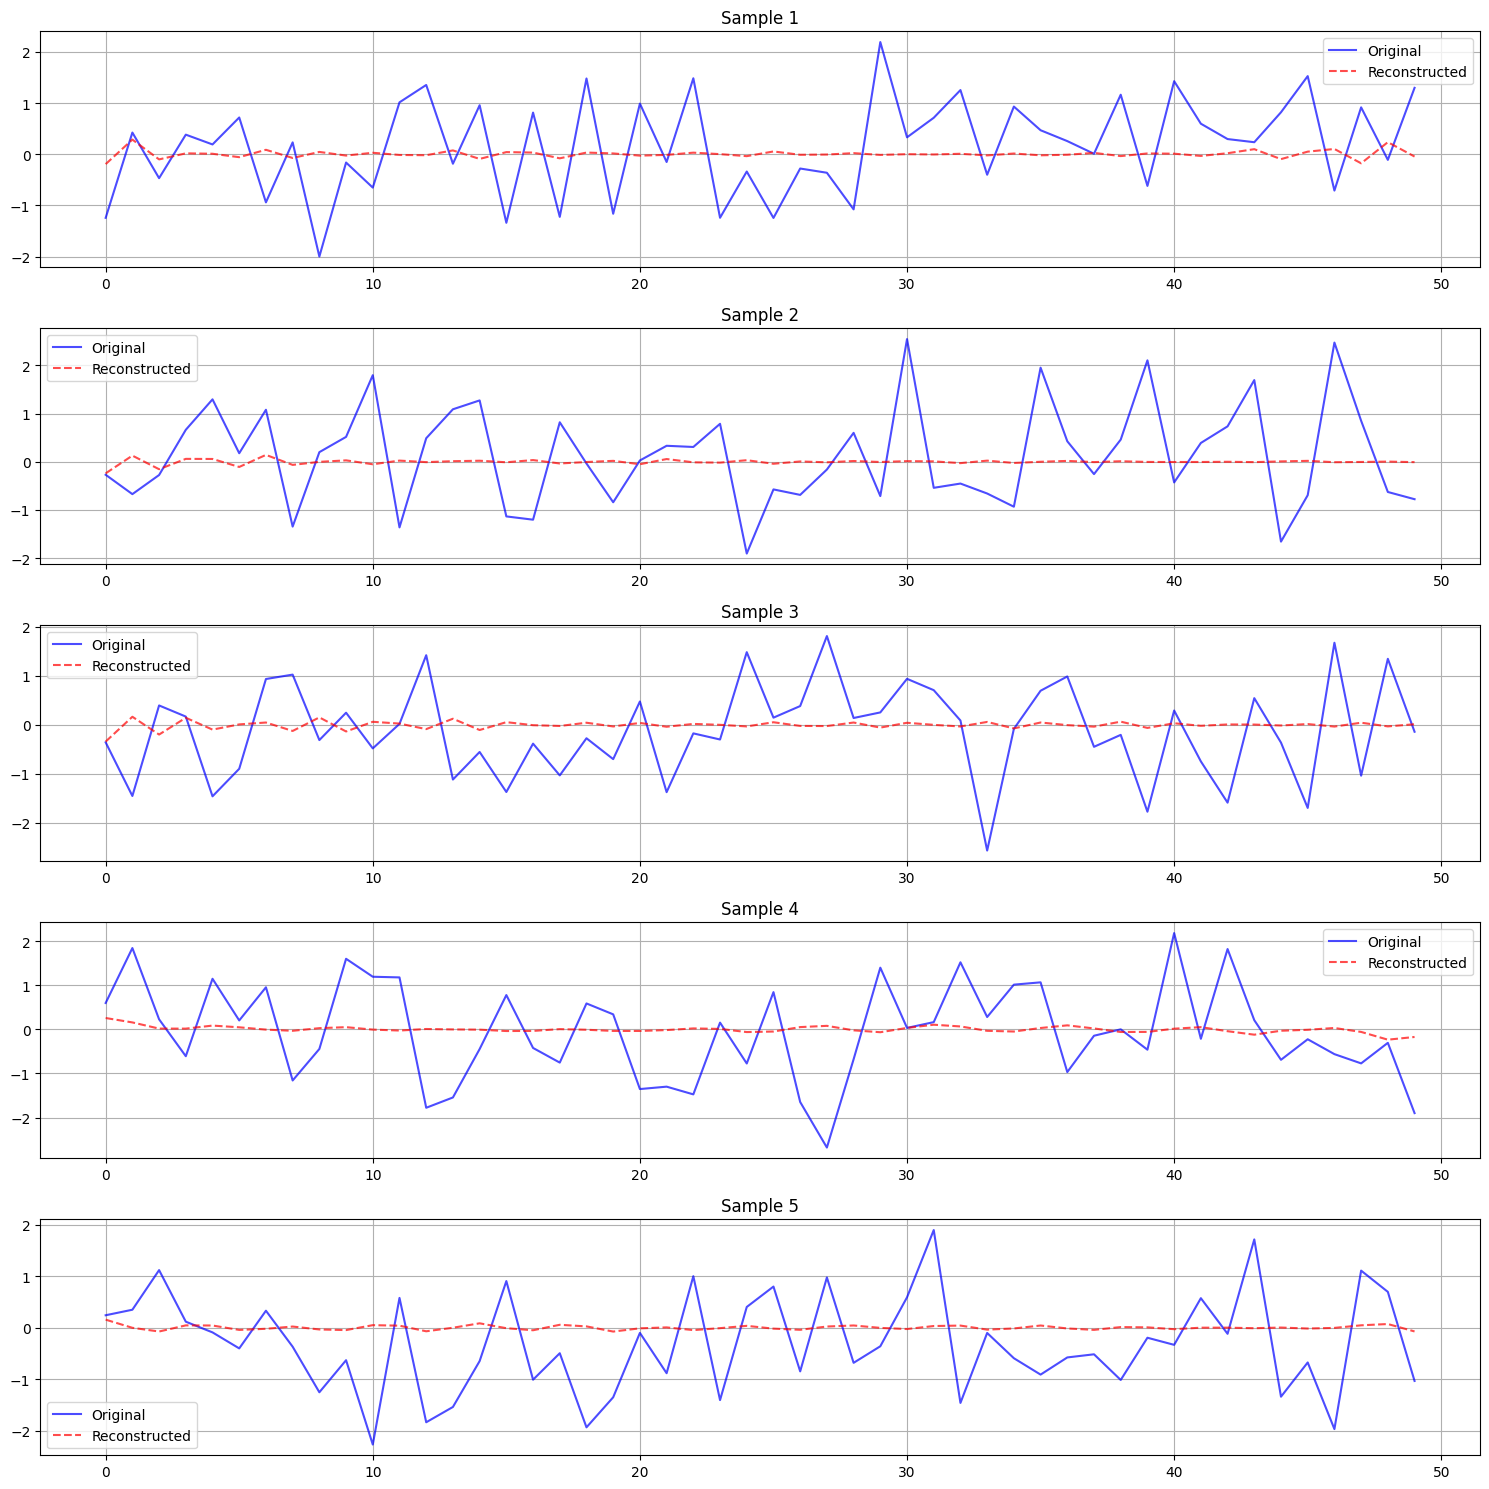


Visualizing latent space...


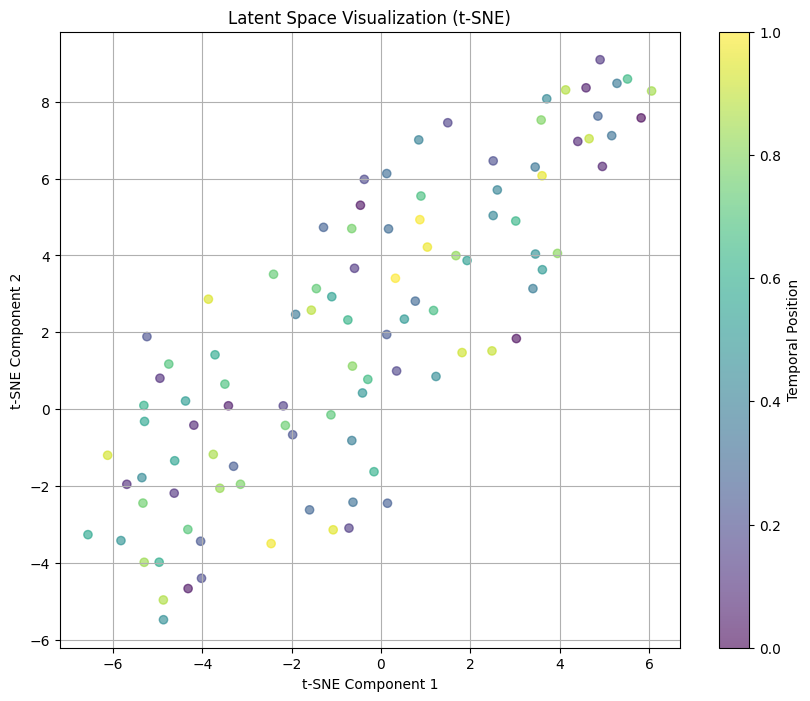


Plotting sequence heatmap...


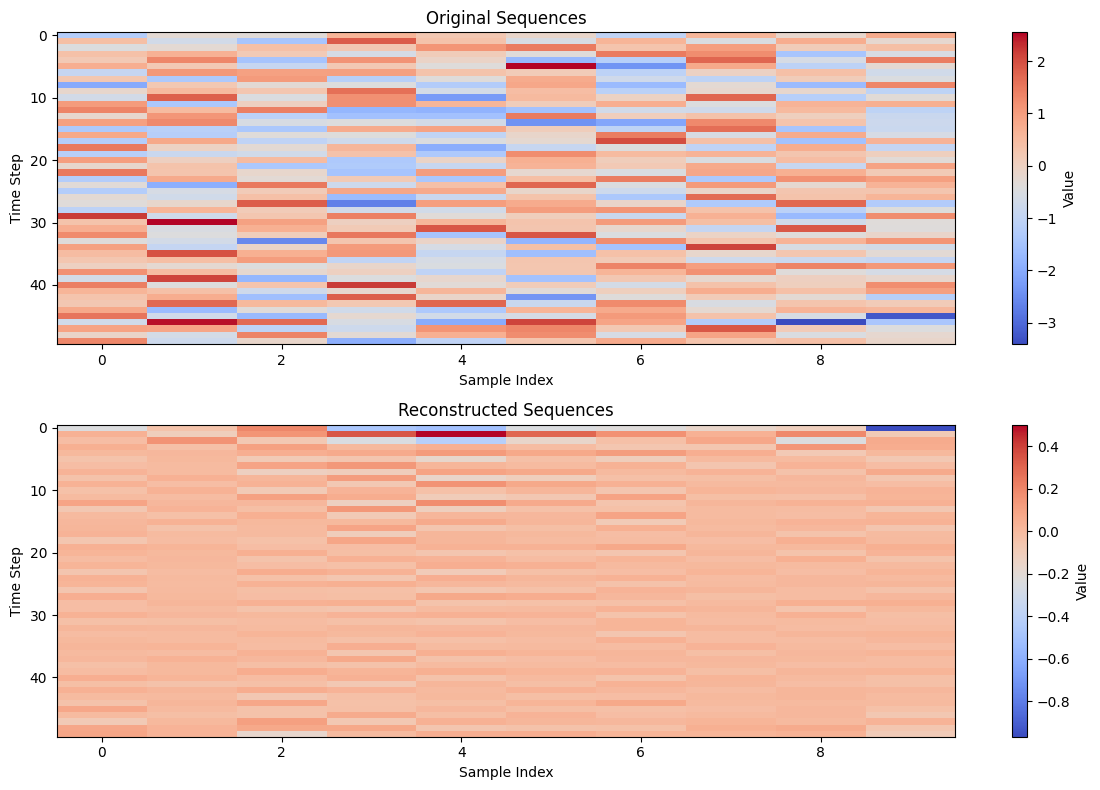


Plotting training history...


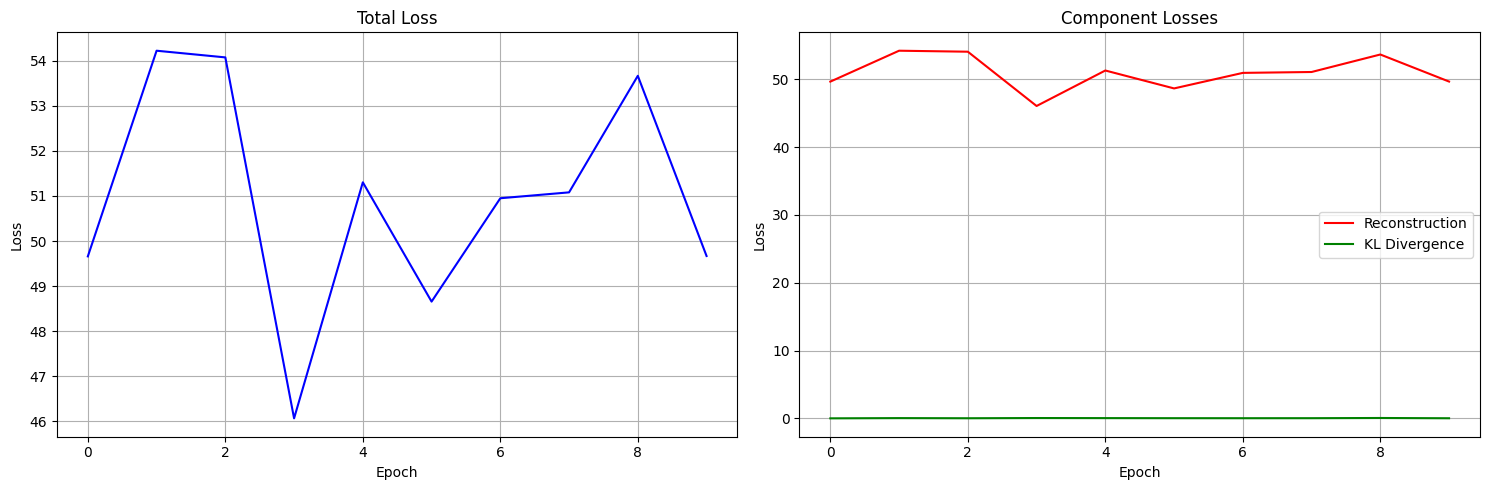


Test Set MSE: 1.0084


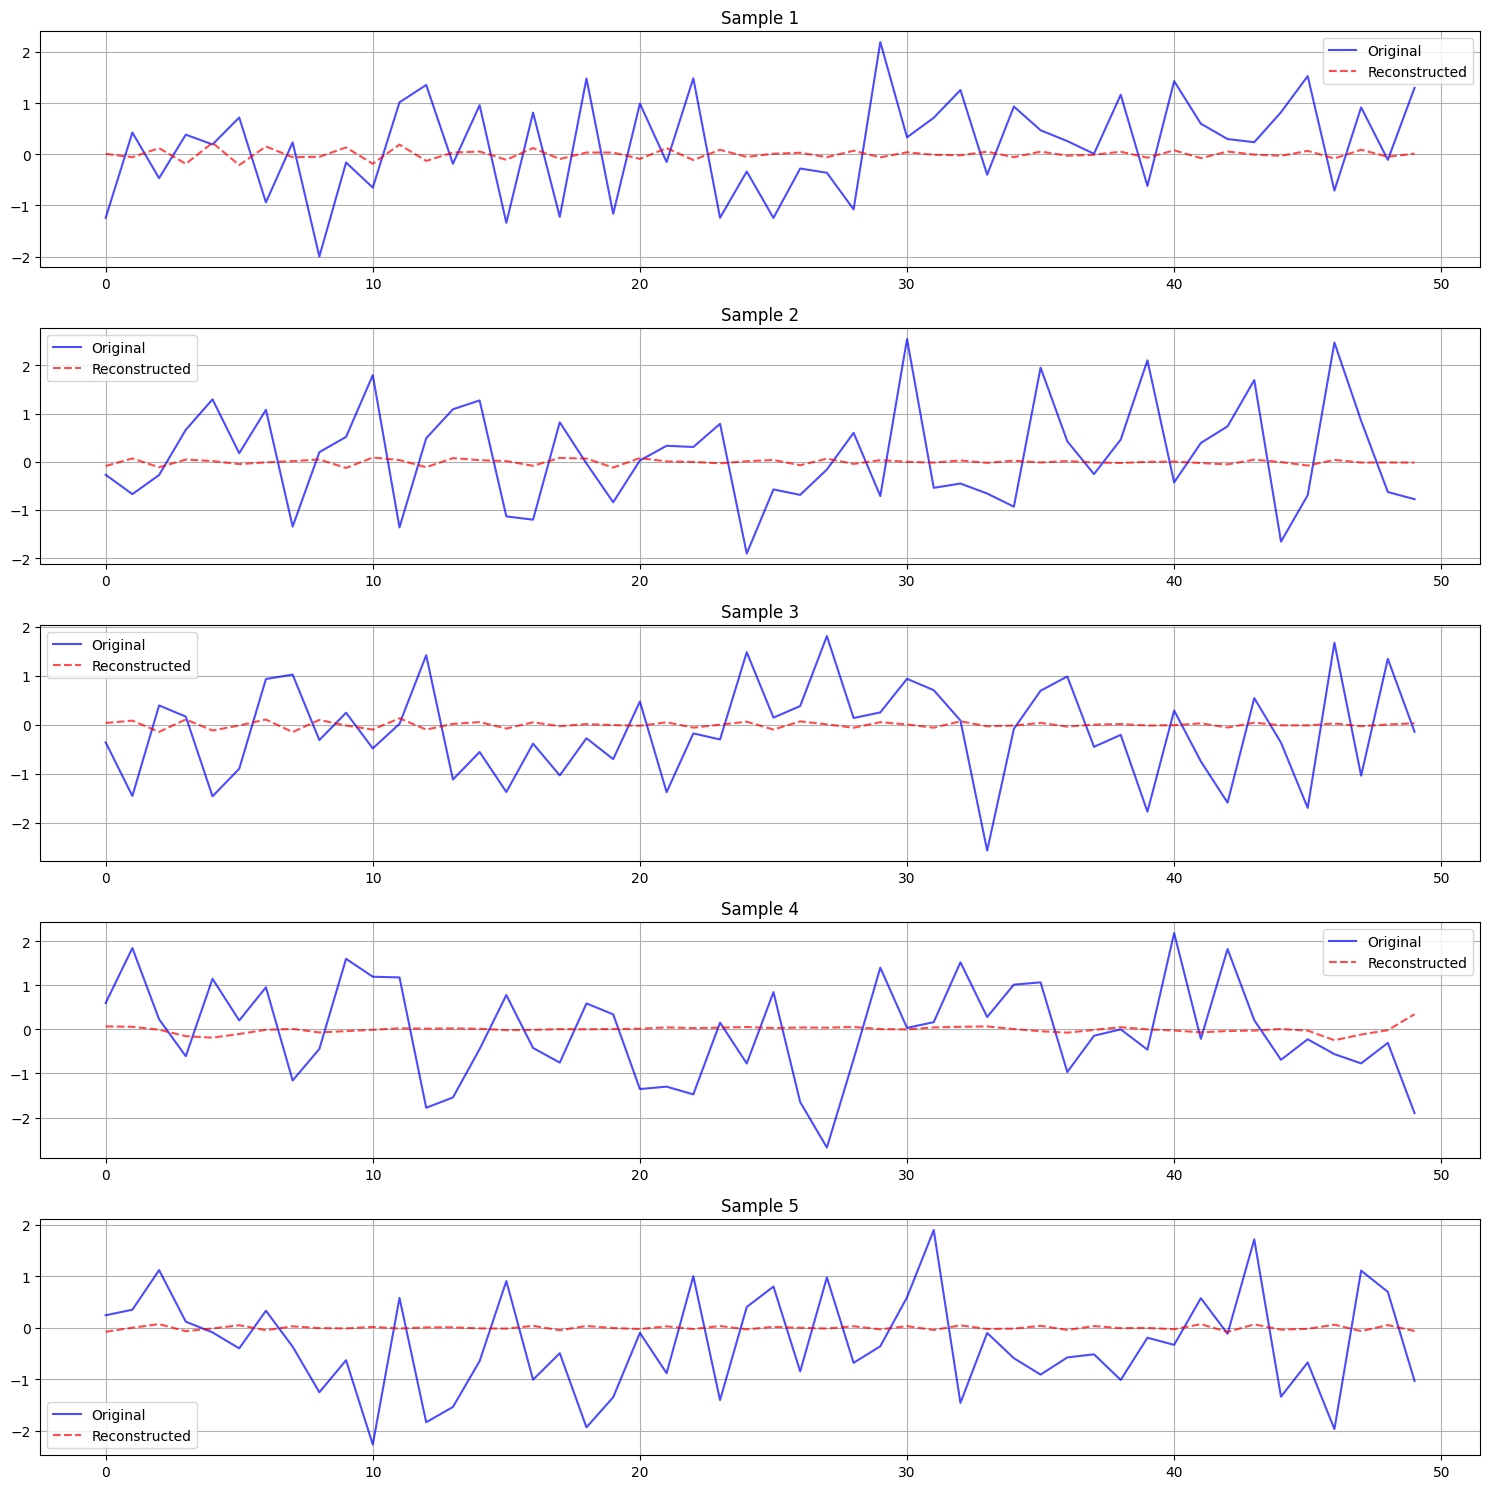

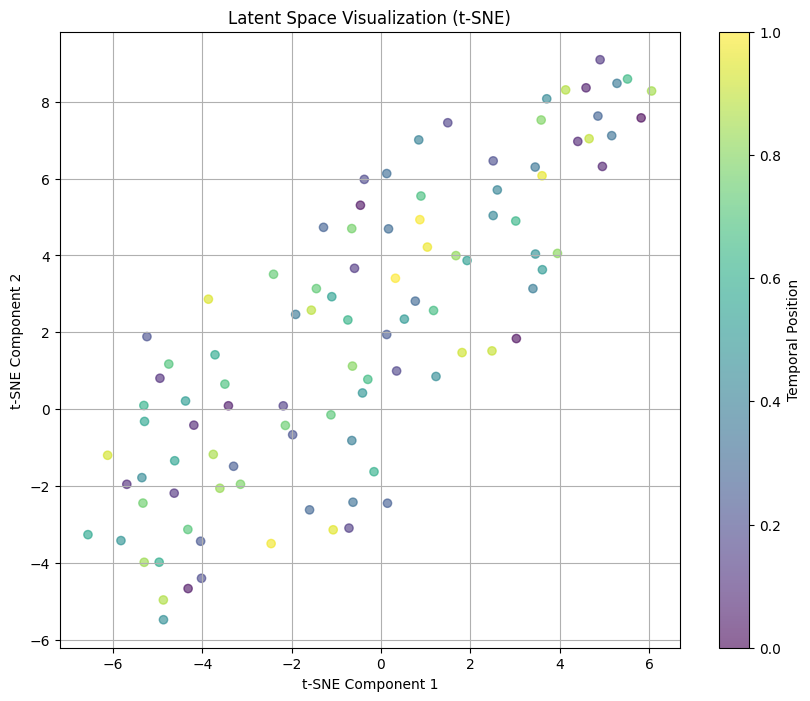

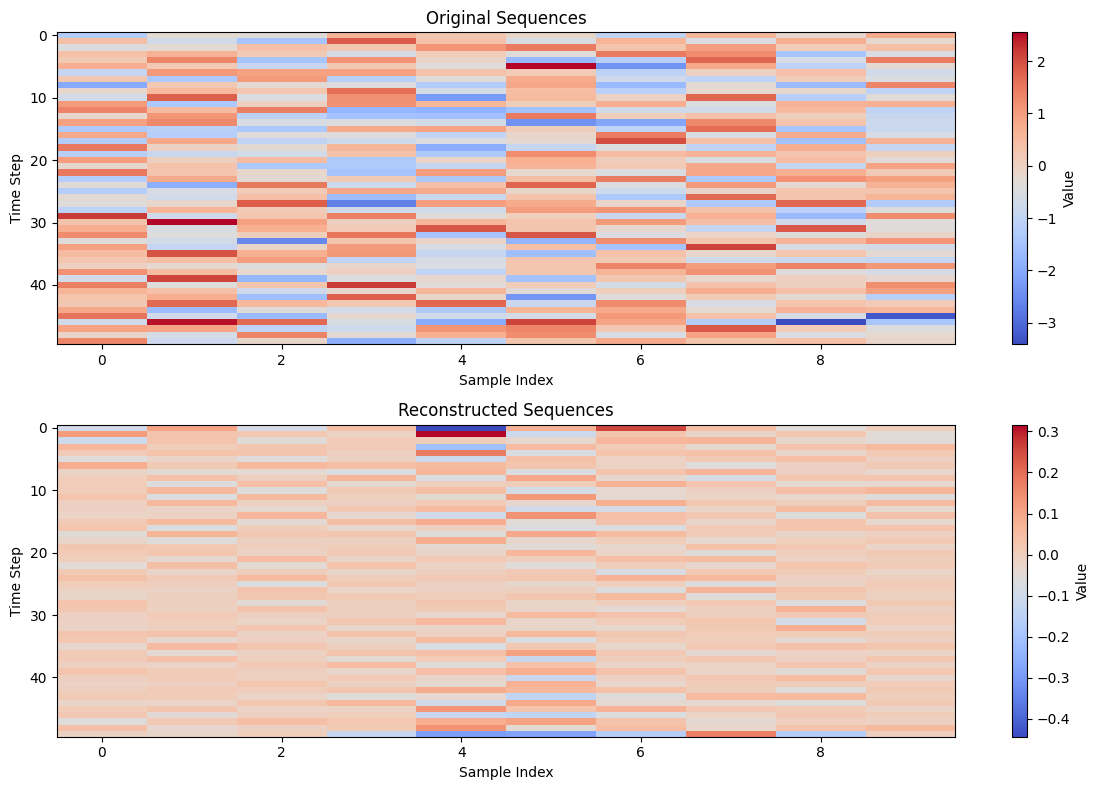

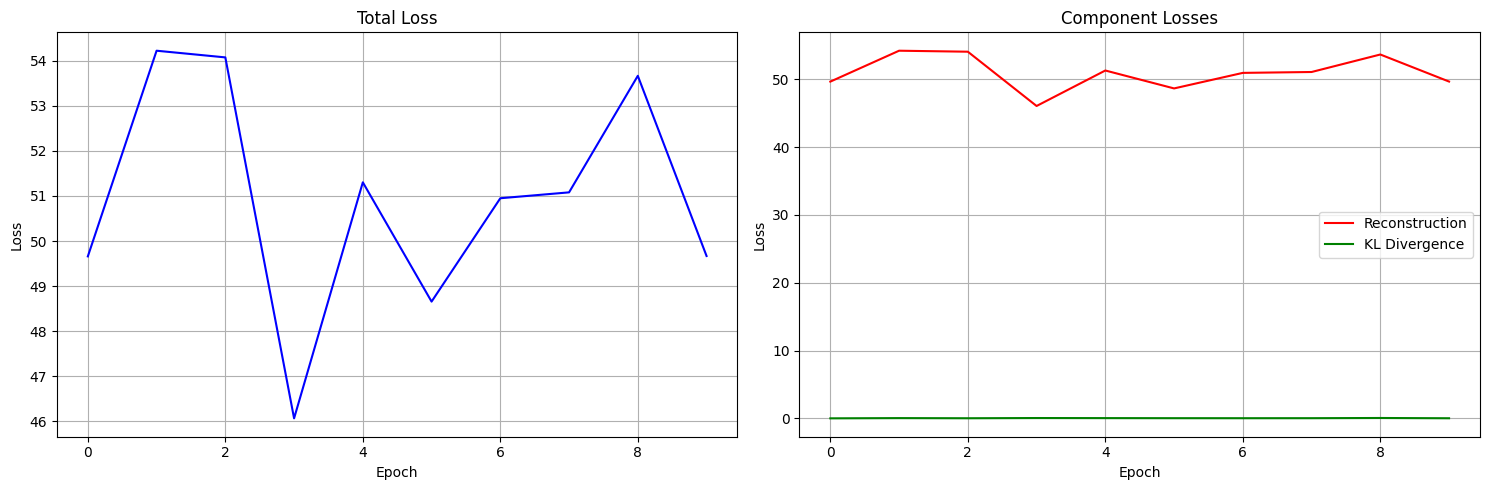

In [ ]:
#  test data
X_test = np.random.randn(100, 50, 1)  # TODO: use real test data

# complete analysis
analyze_model_performance(model, X_test, history)

# individual plots:
fig = plot_reconstructions(model, X_test, num_examples=5)
plt.show()

fig = visualize_latent_space(model, X_test, num_samples=100)
plt.show()

fig = plot_sequence_heatmap(model, X_test, num_samples=10)
plt.show()
